Author: Carl Ingebretsen
Stellar class project fall 2023


In [1]:
#Import libraries to use
import astropy as ap
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt

#Define the constants used in the matter
M = 1.75 #solar masses
#M=1.5
#M=1.0
M_sun = 1.98e33 #g
#X=0.7381 #hydrogen mass fraction
#Y=0.2485
X=0.70
Y=0.27
Z=1-X-Y #metallicity
Z = 0.03
R_sol=6.96e11 #in cm
mu=4/(3+5*X) #total mean molecular weight
mu_e=2/(1+X) #electron mean molecular weight
#nab_ad=0.4 #the adiabatic nabla
a=7.565767e-15 #erg cm-3 K-4 radiation constant
k=1.3806503e-16 #erg K-1 Boltzmann constant
op_file='' #the name of the opacity file
m_h=1.6726e-24 #g mass of a proton
G=6.67e-8 #gravitational constant
N_A=6.022e23 #Avagadro's number
sig=5.56e-5 #Stefan_Boltzmann constant
c=2.99792458e10 #cm/s
Na=6.022e23
Rg=8.314
#

In [2]:
#this part was done with the help and advice of Koji because I apparently was interpolating the opacities wrong

file_name = 'GN93hz.txt'
start_line = 242
table_row_length = 77
tables = {}

with open(file_name) as f:
    lines = f.readlines()

for i in range(126):
    table = {}
    title_items = lines[start_line + table_row_length * i - 1].split()

    table_name = f'Table {title_items[2]}'
    if i < 99:
        X = float(title_items[5].split('=')[1])
        Y = float(title_items[6].split('=')[1])
        Z = float(title_items[7].split('=')[1])
        dXc = float(title_items[8].split('=')[1])
        dXo = float(title_items[9].split('=')[1])
    else:
        X = float(title_items[4].split('=')[1])
        Y = float(title_items[5].split('=')[1])
        Z = float(title_items[6].split('=')[1])
        dXc = float(title_items[7].split('=')[1])
        dXo = float(title_items[8].split('=')[1])

    table['Composition'] = {'X': X, 'Y': Y, 'Z': Z, 'dXc': dXc, 'dXo': dXo}
    log_R_str = lines[start_line + table_row_length * i + 4 - 1].split()[1:]
    log_R = np.array([float(t) for t in log_R_str])
    table['log_R'] = log_R
    table_val = np.zeros((70, len(log_R)))
    log_T = []
    for j in range(70):
        line_to_process = lines[start_line + table_row_length * i + 5 + j].split()
        log_T.append(float(line_to_process[0]))
        val_str = lines[start_line + table_row_length * i + 5 + j].split()[1:]
        val = np.array([float(t) for t in val_str])
        table_val[j, 0:val.shape[0]] = val
    table['name'] = table_name
    table['log_T'] = np.array(log_T)
    table['val'] = table_val
    tables[table_name] = table


def get_opacity_table(X, Y, Z):
    for i, table_name in enumerate(tables.keys()):
        if tables[table_name]['Composition']['X'] == X and tables[table_name]['Composition']['Y'] == Y and tables[table_name]['Composition']['Z'] == Z:
            table = tables[table_name]
            break
        if i == len(tables.keys()) - 1:
            raise ('Not found')
    return table

In [3]:
table = get_opacity_table(X, Y, Z)
opacity_interp = sc.interpolate.RegularGridInterpolator((table['log_T'], table['log_R']), table['val'], bounds_error=False)
table

{'Composition': {'X': 0.92, 'Y': 0.0, 'Z': 0.08, 'dXc': 0.0, 'dXo': 0.0},
 'log_R': array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. ,
        -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 'name': "Table $G&N'93",
 'log_T': array([3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
        4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
        4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
        5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 ,
        5.95, 6.  , 6.1 , 6.2 , 6.3 , 6.4 , 6.5 , 6.6 , 6.7 , 6.8 , 6.9 ,
        7.  , 7.1 , 7.2 , 7.3 , 7.4 , 7.5 , 7.6 , 7.7 , 7.8 , 7.9 , 8.  ,
        8.1 , 8.3 , 8.5 , 8.7 ]),
 'val': array([[-0.677, -0.845, -1.04 , ..., -0.033,  0.364,  0.706],
        [-0.44 , -0.485, -0.571, ...,  0.228,  0.601,  0.931],
        [-0.404, -0.398, -0.394, ...,  0.673,  0.969,  1.301],
        ...,
        [-0.581, -0.581, -0.581, ...,  0.   ,  0.   ,  0.   ],


In [4]:
def check_opac(rho, T):
    '''This function makes sure the density and temperature are accpetable to the opacity table
    then it returns an opacity value
    Inputs:
    rho: the density as a scalar
    T: the temperature as a scalar
    Returns:
    kappa: opacity as a scalar'''
    R = rho / (T*1e-6)**3
    if not isinstance(R, np.ndarray):
        if R < 1e-8:
            R = 1e-8
    log_R = np.log10(R)
    log_T = np.log10(T)

    if not isinstance(T, np.ndarray):
        if log_T < 3.75 or log_T > 8.70:
            if log_T > 8.70:
                log_T = 8.70
            if log_T < 3.75:
                log_T = 3.75
            # raise ValueError('log_T out of range')

    if not isinstance(R, np.ndarray):
        if log_R < -8.0 or log_R > 1.0:
            if log_R > 1.0:
                log_R = 1.0
            if log_R < -8.0:
                log_R = -8.0
            raise ValueError('log_R out of range')

    log_kappa = opacity_interp((log_T, log_R))
    return 10**log_kappa

In [5]:
def load_interpolate_op():
    '''This function interpolates the opacities for the table to fit the grid size we need 
    for the computation. It will return a function of the interpolated table.'''
    #I need to see how to reference the values output 
    
    #First get the table loaded
    #Column 0 is log(T)
    #R is in values  density/T6**3 where T6=1e-6 T in Kelvin
    #file_name='Test_opacity_table.txt'
    file_name='Solar_comp_4.txt'
    R = np.array([-8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0])
    #R=R[:19]
    data = np.genfromtxt(file_name,dtype='float',delimiter=',')
    print("opacity data: ",data)
    #The first column is log T [:,0]
    #T_vals = 10**data[:,0]*10**6
    T_vals = data[:,0]
    #T_vals=T_vals[:19]
    opacities = 10**data[:,1:] #set the opacity table
    print("opacity shape",opacities.shape)
    print("length of r vals", len(R))
    print("length of t vals", len(T_vals))
    print("T vals", T_vals)
    #R=R[:15]
    #R_vals=10**R/(T_vals/10**6) #probably log10 so need 10** but maybe e**
    #R_vals=R*(T_vals/10**6)**3#This needs a lot more checking / or * I think *
    R_vals=R
    print("R_vals: ", R_vals)
    
    #Now interpolate the table in 2d
    #opacity_func=sc.interpolate.interp2d(R_vals,T_vals,opacities,kind='cubic')
    #opacity_func=sc.interpolate.RectBivariateSpline(R_vals,T_vals,opacities)
    opacity_func=sc.interpolate.RectBivariateSpline(T_vals,R_vals,opacities)
    #Check both
    return opacity_func

In [6]:
def eq_of_state(rho,T):
    '''This equation calculates the equation of state of the gas accounting for the gas and 
    radiation pressure.
    Inputs: 
    rho: the density at the point
    T: the temperature at the point
    Returns: The Pressure P at that point in mass'''
    #return rho*k*T/(mu*m_h)+(1/3)*a*T**4
    return rho*Na*k*T/mu+(1/3)*a*T**4

In [7]:
def calc_density(P,T):
    '''calculates density
    The inputs are pressure P and Temperature T as scalar floats
    Returns density as a scalar'''
    return (P/T-a*T**3/3)*mu/(Na*k)

In [8]:
def get_opacity(interp, rho, T):
    '''This is a second attempt at an opacity getting function'''
    R = rho / (T*1e-6)**3
    if R < 1e-8:
        R = 1e-8
    log_R = np.log10(R)
    log_T = np.log10(T)

    if log_T < 3.75 or log_T > 8.70:
        if log_T > 8.70:
            log_T = 8.70
        if log_T < 3.75:
            log_T = 3.75
        # raise ValueError('log_T out of range')
    if log_R < -8.0 or log_R > 1.0:
        if log_R > 1.0:
            log_R = 1.0
        if log_R < -8.0:
            log_R = -8.0
        # raise ValueError('log_R out of range')

    log_kappa = interp((log_T, log_R))
    return 10**log_kappa



In [9]:
def nuc_energy(rho,T):
    """This function calculates the energy generation rate of each cell of mass. It takes into
    account both the pp-chain (all three) and the CNO cycle.
    Inputs:
    rho: the density at the point of mass
    T: the temperature at the mass point
    Returns:
    eps: the total energy generation rate at that point of mass"""
    #set T scales
    T_7=T/10**7; T_9=T/10**9
    #Set psi factor
    if T<10**7:
        psi=1.0
    elif T>10**7 and T<10**8: #Check this criteria more carfully!!
        psi=2.0
    else:
        psi=1.5
    
    #Set weak screening
    xi=1.0# check this factor more carefully #Z_1=Z_2=1 because its hydrogen
    #print("rho, t_7",rho,T_7)
    if rho/T_7**3<0:
        rho=0.0
        
    f_11 = np.exp((5.92e-3)*(xi*rho/T_7**3)**0.5)
    #if f_11>5.0:
        #f_11=2.0
           
    #print("f_11",f_11)
    g_11=1+3.82*T_9+1.51*T_9**2+0.144*T_9**3-0.0114*T_9**4
    eps_pp=(2.57e4)*psi*f_11*g_11*rho*X**2*T_9**(-2/3)*np.exp(-3.381/T_9**(1/3)) #pp chain energy
    
    #Set up CNO cycle
    g_141=1-2.00*T_9+3.41*T_9**2-2.43*T_9**3
    eps_CNO=(8.24e25)*g_141*Z*X*rho*T_9**(-2/3)*np.exp(-15.231*T_9**(-1/3)-(T_9/0.8)**2) #CNO energy
    
    #A fudge factor
    #f=0.75*Z
    f=0.71*Z
    #f=1.0
    
    return eps_pp+f*eps_CNO

In [10]:
def rad_nab(m,L,P,T,kap):
    '''Calculate the nabla for radiative transport'''
    return 3/(16*a*c*G*np.pi)*(L*P)/(m*T**4)*kap

def ad_nab(T,P):
    '''Calculate the nabla for convective transport'''
    #b=1-((1/3)*a*T**4/P)
    P_rad = 1/3 * a * T**4
    b = 1 - (P_rad / P)
    return (1 + (1-b)*(4+b)/b**2)/(5/2 + 4*(1-b)*(4+b)/b**2)

In [11]:
def stellar_equations(m,vec):
    '''Stellar equaitons
    Use L, P, R, T format in the vector input
    m: is the mass coordinate as a scalar'''
    L,P,R,T=vec
    rho=calc_density(P,T)
    kap=check_opac(rho,T)
    del_ad=ad_nab(T,P)
    del_rad=rad_nab(m,L,P,T,kap)
    
    #The four stellar equations
    dldm=nuc_energy(rho,T)
    dPdm=-G*m/(4*np.pi*R**4)
    drdm=1/(4*np.pi*R**2*rho)
    if del_rad<del_ad:
        dTdm=-G*m/(4*np.pi*R**4)*(T/P)*del_rad
    else:
        dTdm=-G*m/(4*np.pi*R**4)*(T/P)*del_ad
    
    return np.array([dldm,dPdm,drdm,dTdm])

In [12]:
def load1(P_cent,T_cent):
    '''load1'''
    f=1e-10
    dM=f*M_sun*M
    rho=calc_density(P_cent,T_cent) #central density
    #May need a rho cut-off
    dr=(3*dM/(4*np.pi*rho))**(1/3)
    dP=P_cent-(3*G/8/np.pi)*(4*np.pi*rho/3)**(4/3)*dM**(2/3)
    dL=nuc_energy(rho,T_cent)*dM
    dT=T_cent
    print("dl cent",dL)
    print("dP cent",dP)
    print("dr cent",dr)
    print("dT cent",dT)
    
    return np.array([dL,dP,dr,dT])

In [13]:
def Eddington_derivative(tau, P, vars_st):
    L, R, T = vars_st
    T = (3/4 * L / (4 * np.pi * sig * R**2) * (tau + 2/3))**(1/4)
    rho = calc_density(P, T)
    kappa = check_opac(rho, T)
    dPdtau = G * M * M_sun / R**2 / kappa
    return dPdtau

In [14]:
def load2(R_star,L_star):
    '''load 2'''
    '''Second load function'''
    #This function makes l,p,r,t at the surface for each round
    #L and R are free parameters for the surface boundary
    #Define the surface at tau=2/3
    T = (L_star/(4*np.pi*R_star**2*sig))**(1/4) #From luminosity equation
    #Get opacity at surface for Pressure equation
    #Need a density at the surface that's not zero
    
    vars_st=np.array([L_star,R_star,T])
    P_bound=(1/3)*a*T**4
    P_vals=sc.integrate.solve_ivp(Eddington_derivative, y0=[P_bound], t_span=(0, 2/3), t_eval=np.linspace(0, 2/3), args=[vars_st], method='RK45').y
    P_surf=P_vals.max()
    #P_surf=1e-2
    print("dl surf",L_star)
    print("dP surf",P_surf)
    print("dr surf",R_star)
    print("dT surf",T)
    #Its kappa that's being returned as an array
    
    return np.array([L_star,P_surf,R_star,T])


In [15]:
def do_integration(L,P,R,T,steps=100):
    '''This function computes the inward and outward integrations.'''
    cent_1=load1(P,T)
    surf_1=load2(R,L)
    #Now do RK4 from here 
    f=1e-8
    #f=0.01
    check_point=0.5
    #check_point=0.6
    #check_point=0.55
    #check_point=0.58
    M_start=M*M_sun*f #Choose a step size
    M_array_out=np.linspace(f, check_point, steps)*M*M_sun
    out_dir = sc.integrate.solve_ivp(stellar_equations,(M_start,M*M_sun/2),cent_1)
    out_dir=sc.integrate.solve_ivp(stellar_equations, (M_array_out[0], M_array_out[-1]), cent_1, method='RK45', t_eval=M_array_out)
    M_array_in=np.linspace(1, check_point, steps)*M*M_sun
    in_dir = sc.integrate.solve_ivp(stellar_equations, (M_array_in[0], M_array_in[-1]), surf_1, method='RK45', t_eval=M_array_in)
    #return in_result,out_result
    return in_dir, out_dir

In [16]:
def minimization_function(init_val):
    '''This function will check the tolerance of the integrations and adjust the inward and outward starting points 
    for the next round of integrations.'''
    #Check at a mid point for correspondance
    #set a tolerance
    #T,P,L,R format
    
    in_res,out_res=do_integration(init_val[0],init_val[1],init_val[2],init_val[3])
    in_dat=in_res.y; out_dat=out_res.y
    m_in=in_res.t
    in_r=in_res.y
    m_out=out_res.t
    out_r=out_res.y
    print("m_inner end", m_in[-1])
    print("m_outer end", m_out[-1])
    
    #These are in l,p,r,t format
    T_dif=in_dat[3][-1]-out_dat[3][-1]
    P_dif=in_dat[1][-1]-out_dat[1][-1]
    L_dif=in_dat[0][-1]-out_dat[0][-1]
    R_dif=in_dat[2][-1]-out_dat[2][-1]
    #T_dif=in_dat[3][0]-out_dat[3][-1]
    #P_dif=in_dat[1][0]-out_dat[1][-1]
    #L_dif=in_dat[0][0]-out_dat[0][-1]
    #R_dif=in_dat[2][0]-out_dat[2][-1]
    scale = (in_res.y[:, 0] - out_res.y[:, 0])
    
    #The quantity to minimize
    minimize = np.array([(L_dif/scale[0])**2,(P_dif/scale[1])**2,(R_dif/scale[2])**2,(T_dif/scale[3])**2])
    print("minimized quantity: ", minimize)
    
    return minimize

In [89]:
# Initial guess
# homology relations for low-mass stars
Rs=6.96e10
#Rs=
Ls=3.8e33
#R = Rs * (M)**0.75
R=0.87*Rs
R=61175376181.39762
R=6.0e9
L = Ls * (M)**3.5

# Try Solar vals
#P = 1.92e17
#T = 1.57e7
#P=1.3e17
#T=1.4e7
#These values above work for 1 Msun
#Not for 1.75 M_sun going out
#P=2e18 #This seems to work for 1.75
#T=3e7#This seems
#Pc=1.7e17 #This seems to work for 1.75
#Tc=1.9e7#This seems
Pc=1.75e17 #This seems to work for 1.75
Pc=0.75e17
#Tc=1.85e7#This seems
Tc=1.7e7

#Pc=1.4e17 #This seems to work for 1.75
#Tc=1.6e7#This seems

#P=3e16 #This seems to work for 1.75
#T=2.5e7#This seems
#R=3e11
#L=8e34

#Rc = 1e12
#Lc = 1.9e34
Lc=1e34
Rc=1.5e11

global opac_func
opac_func=load_interpolate_op()

inner,outer=do_integration(Lc,Pc,Rc,Tc, steps=100)

opacity data:  [[ 3.75  -0.767 -0.928 ... -0.645 -0.261  0.131]
 [ 3.8   -0.561 -0.598 ... -0.18   0.121  0.429]
 [ 3.85  -0.534 -0.53  ...  0.384  0.628  0.894]
 ...
 [ 8.3   -0.633 -0.633 ...  0.     0.     0.   ]
 [ 8.5   -0.704 -0.704 ...  0.     0.     0.   ]
 [ 8.7   -0.582 -0.753 ...  0.     0.     0.   ]]
opacity shape (70, 19)
length of r vals 19
length of t vals 70
T vals [3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2  4.25 4.3  4.35 4.4
 4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9  4.95 5.   5.05 5.1
 5.15 5.2  5.25 5.3  5.35 5.4  5.45 5.5  5.55 5.6  5.65 5.7  5.75 5.8
 5.85 5.9  5.95 6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
 7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.3  8.5  8.7 ]
R_vals:  [-8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5
 -1.  -0.5  0.   0.5  1. ]
dl cent 1.6707924581848095e+25
dP cent 7.499997242312603e+16
dr cent 13644799.805131214
dT cent 17000000.0
dl surf 1e+34
dP surf 27747.13993626416
dr surf 15

in_res[0] [1.00000000e+34 1.00000000e+34 1.00000000e+34 1.00000000e+34
 9.99999999e+33 9.99999997e+33 9.99999993e+33 9.99999984e+33
 9.99999969e+33 9.99999944e+33 9.99999905e+33 9.99999848e+33
 9.99999766e+33 9.99999650e+33 9.99999494e+33 9.99999287e+33
 9.99999020e+33 9.99998679e+33 9.99998248e+33 9.99997710e+33
 9.99997044e+33 9.99996232e+33 9.99995252e+33 9.99994082e+33
 9.99992699e+33 9.99991082e+33 9.99989193e+33 9.99986989e+33
 9.99984430e+33 9.99981469e+33 9.99978060e+33 9.99974157e+33
 9.99969709e+33 9.99964667e+33 9.99958977e+33 9.99952587e+33
 9.99945440e+33 9.99937480e+33 9.99928644e+33 9.99918841e+33
 9.99907975e+33 9.99895946e+33 9.99882650e+33 9.99867980e+33
 9.99851824e+33 9.99834070e+33 9.99814599e+33 9.99793291e+33
 9.99770021e+33 9.99744661e+33 9.99717080e+33 9.99687143e+33
 9.99654712e+33 9.99619646e+33 9.99581799e+33 9.99541023e+33
 9.99497198e+33 9.99450133e+33 9.99399586e+33 9.99345310e+33
 9.99287047e+33 9.99224533e+33 9.99157496e+33 9.99085658e+33
 9.99008730e+3

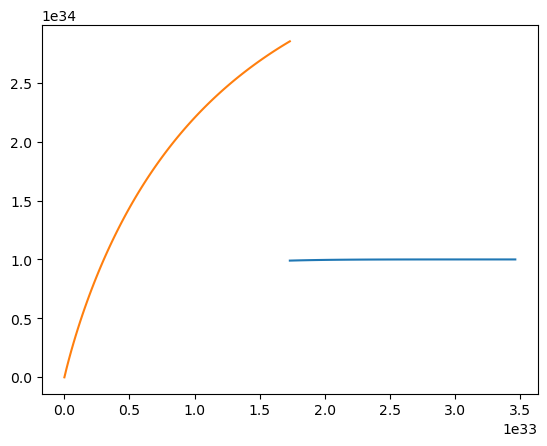

In [90]:
m_in=inner.t
in_res=inner.y
m_out=outer.t
out_res=outer.y

plt.plot(m_in,in_res[0])
plt.plot(m_out,out_res[0])
print("in_res[0]",in_res[0])
#plt.loglog(m_in,in_res[0])
#plt.loglog(m_out,out_res[0])
#plt.hlines(1e33,m_out[0],m_out[-1])
plt.show()

dl cent 1.6707924581848095e+25
dP cent 7.499997242312603e+16
dr cent 13644799.805131214
dT cent 17000000.0
dl surf 1e+34
dP surf 27747.13993626416
dr surf 150000000000.0
dT surf 5022.075142966041
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [3.46144034e+00 1.32276375e-02 7.81888439e-05 1.07687892e-01]
dl cent 1.6707924581848095e+25
dP cent 7.499997242312603e+16
dr cent 13644799.805131214
dT cent 17000000.0
dl surf 1e+34
dP surf 27747.13993626416
dr surf 150000000000.0
dT surf 5022.075142966041
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [3.46144034e+00 1.32276375e-02 7.81888439e-05 1.07687892e-01]
dl cent 1.6707924581848095e+25
dP cent 7.499997242312603e+16
dr cent 13644799.805131214
dT cent 17000000.0
dl surf 1e+34
dP surf 27747.13993626416
dr surf 150000000000.0
dT surf 5022.075142966041
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [3.46144034e+00

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.26678689 0.02285148 0.00249184 0.02750709]
dl cent 1.8583647729298113e+25
dP cent 8.869342235086963e+16
dr cent 12825715.148834491
dT cent 16706324.469088554
dl surf 1.2327203246323824e+34
dP surf 3432.507221492469
dr surf 446685202240.1868
dT surf 3066.508638940519
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.26678687 0.02285148 0.00249184 0.02750709]
dl cent 1.858364800909461e+25
dP cent 8.869342367250443e+16
dr cent 12825715.084987057
dT cent 16706324.469088554
dl surf 1.2327203062634183e+34
dP surf 3432.5071989463227
dr surf 446685202240.1868
dT surf 3066.508627516884
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.2667869  0.02285147 0.00249184 0.02750709]
dl cent 1.8583647729298113e+25
dP cent 8.869342235086963e+16
dr cent 12825715.148834491
dT cent 16706324.469088554
dl surf 1.2327203062634183

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.17580021 0.01915369 0.00173739 0.01092552]
dl cent 1.7897598637333144e+25
dP cent 8.740510467269739e+16
dr cent 12860269.801798774
dT cent 16597504.562966151
dl surf 1.2647522426526373e+34
dP surf 6396.569914404615
dr surf 329080307266.4287
dT surf 3595.66525552336
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.1758002  0.01915369 0.00173739 0.01092553]
dl cent 1.7897599561313906e+25
dP cent 8.740510467269808e+16
dr cent 12860269.866237123
dT cent 16597504.810288243
dl surf 1.2647522426526373e+34
dP surf 6396.570104960672
dr surf 329080302362.75006
dT surf 3595.6652823131535
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.17580029 0.0191537  0.00173739 0.01092553]
dl cent 1.7201534960816965e+25
dP cent 8.509748378590699e+16
dr cent 12959765.471527724
dT cent 16536831.300865922
dl surf 1.283836684377785

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.056482   0.01083212 0.00070814 0.00043866]
dl cent 1.6543590954961752e+25
dP cent 8.523174606063586e+16
dr cent 12900871.928094707
dT cent 16339896.957683086
dl surf 1.3261291529766034e+34
dP surf 12374.767775075004
dr surf 239093781796.41916
dT surf 4268.65593591092
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.056482   0.01083212 0.00070814 0.00043866]
dl cent 1.6543591204096806e+25
dP cent 8.523174733068768e+16
dr cent 12900871.86387994
dT cent 16339896.957683086
dl surf 1.3261291332157393e+34
dP surf 12374.767694036043
dr surf 239093781796.41916
dT surf 4268.655920008938
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [0.056482   0.01083212 0.00070814 0.00043866]
dl cent 1.6543590954961752e+25
dP cent 8.523174606063586e+16
dr cent 12900871.928094707
dT cent 16339896.957683086
dl surf 1.32612913321573

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [2.78931844e-03 2.58262596e-03 6.24036290e-05 2.95571195e-03]
dl cent 1.4172022435847746e+25
dP cent 8.014005533203197e+16
dr cent 13044273.69126072
dT cent 15883505.208020087
dl surf 1.4438850063534988e+34
dP surf 21184.08484957209
dr surf 186210365516.70044
dT surf 4940.945476405729
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [7.04019599e-04 2.44187272e-03 7.35257542e-06 5.94417160e-04]
dl cent 1.4172022435847746e+25
dP cent 8.014005533203197e+16
dr cent 13044273.69126072
dT cent 15883505.208020087
dl surf 1.443885027869062e+34
dP surf 21184.084989249524
dr surf 186210365516.70044
dT surf 4940.945494812186
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [7.04018797e-04 2.44187256e-03 7.35257160e-06 5.94417290e-04]
dl cent 1.4172022649316801e+25
dP cent 8.014005652621168e+16
dr cent 13044273.626339076
dT ce

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [5.76760319e-05 1.54799424e-05 2.01639997e-05 5.68683725e-07]
dl cent 9.94296864957701e+24
dP cent 7.1315571863687144e+16
dr cent 13219705.18209802
dT cent 14717575.167987173
dl surf 9.933982897849519e+33
dP surf 25463.95149211494
dr surf 156349055157.56656
dT surf 4910.91093254844
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [5.76784482e-05 1.54800973e-05 2.01640504e-05 5.68973500e-07]
dl cent 8.975446884352581e+24
dP cent 6.898768725615444e+16
dr cent 13266279.27141561
dT cent 14389495.272328643
dl surf 8.730698977851031e+33
dP surf 24817.937952949516
dr surf 153861091679.81097
dT surf 4793.212519473518
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.10689844e-04 3.70067361e-06 5.43831604e-06 2.30186865e-05]
dl cent 9.724328829920148e+24
dP cent 7.0827023972353736e+16
dr cent 13227844.396307286
dT cent 1

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.11612188e-06 3.40883730e-06 5.37616990e-06 5.10649541e-07]
dl cent 9.034081072979165e+24
dP cent 6.915928199576796e+16
dr cent 13261106.591234447
dT cent 14408357.002549842
dl surf 8.861065748609055e+33
dP surf 24783.27142837269
dr surf 154482033501.4067
dT surf 4801.327574335305
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.11646126e-06 3.40891118e-06 5.37619822e-06 5.10358470e-07]
dl cent 8.703340046633965e+24
dP cent 6.833502324179969e+16
dr cent 13277533.218763968
dT cent 14290072.091918051
dl surf 8.45154580007186e+33
dP surf 24525.706128249327
dr surf 153652466731.30887
dT surf 4757.656741019009
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.33517645e-03 1.44594479e-06 2.76035505e-06 4.72133850e-05]
dl cent 8.999651285250067e+24
dP cent 6.9076045439105976e+16
dr cent 13262649.110181656
dT cent 

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.07430621e-06 2.90445826e-06 5.57073230e-06 8.22906149e-07]
dl cent 9.034153986083036e+24
dP cent 6.915989718565902e+16
dr cent 13261065.855652643
dT cent 14408352.618098587
dl surf 8.861070544561306e+33
dP surf 24801.462589677823
dr surf 154425371449.04193
dT surf 4802.208999477888
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.07422807e-06 2.90442281e-06 5.57070932e-06 8.23147738e-07]
dl cent 9.034153849884319e+24
dP cent 6.915989615509642e+16
dr cent 13261065.92162475
dT cent 14408352.618098587
dl surf 8.861070544561306e+33
dP surf 24801.461850707477
dr surf 154425373750.15927
dT surf 4802.208963698644
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.07433539e-06 2.90448300e-06 5.57072018e-06 8.22893565e-07]
dl cent 9.034154260742079e+24
dP cent 6.915989615509703e+16
dr cent 13261065.987907896
dT cent

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.06934855e-06 2.91595030e-06 5.56416407e-06 8.26092166e-07]
dl cent 9.03415833293058e+24
dP cent 6.91599307235233e+16
dr cent 13261063.694912132
dT cent 14408352.573417787
dl surf 8.861070869282218e+33
dP surf 24800.947173525707
dr surf 154426977815.61337
dT surf 4802.184066852255
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.06968077e-06 2.91601848e-06 5.56419294e-06 8.25721665e-07]
dl cent 9.034158454057895e+24
dP cent 6.915993524097682e+16
dr cent 13261063.328948818
dT cent 14408352.32472902
dl surf 8.86107091179167e+33
dP surf 24800.93631829173
dr surf 154427011787.5746
dT surf 4802.183544402196
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.06879447e-06 2.91600634e-06 5.56396174e-06 8.27127044e-07]
dl cent 9.034158454057895e+24
dP cent 6.915993524097682e+16
dr cent 13261063.328948818
dT cent 1440

m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.06860562e-06 2.91643806e-06 5.56371513e-06 8.27250418e-07]
dl cent 9.03415860866129e+24
dP cent 6.915993655394954e+16
dr cent 13261063.241846016
dT cent 14408352.314842803
dl surf 8.861070924132424e+33
dP surf 24800.917019345594
dr surf 154427071937.1232
dT surf 4802.182610845679
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.06860565e-06 2.91643767e-06 5.56371532e-06 8.27250581e-07]
dl cent 9.034158608664056e+24
dP cent 6.915993655395562e+16
dr cent 13261063.241845943
dT cent 14408352.314843835
dl surf 8.861070924131167e+33
dP surf 24800.917027852225
dr surf 154427071910.66
dT surf 4802.182611256968
m_inner end 1.7324999999999998e+33
m_outer end 1.7324999999999998e+33
minimized quantity:  [1.06860568e-06 2.91643700e-06 5.56371552e-06 8.27250920e-07]
dl cent 9.034158608665457e+24
dP cent 6.9159936553958696e+16
dr cent 13261063.241845908
dT cent 14

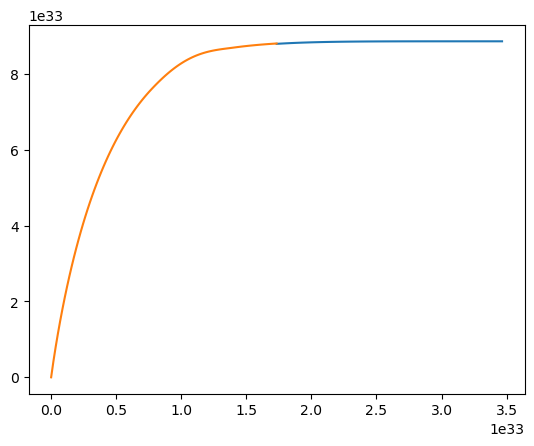

In [91]:
#Do the minimization
result=sc.optimize.root(minimization_function,np.array([Lc,Pc,Rc,Tc]),tol=1e-37,method='lm').x

inner,outer=do_integration(result[0],result[1],result[2],result[3])
m_in=inner.t
in_res=inner.y
m_out=outer.t
out_res=outer.y
print("m_inner end", m_in[-1])
print("m_outer end", m_out[-1])
print("inner,",inner)
print("outer,",outer)
#test_plot(m,inner,outer)
#test_plot_2(in_res,out_res)
#l,p,r,t
#plt.title(Plot of the Luminosity Result)
plt.plot(m_in,in_res[0])
plt.plot(m_out,out_res[0])

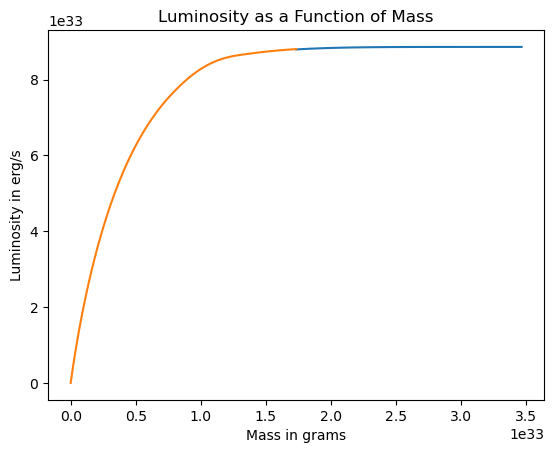

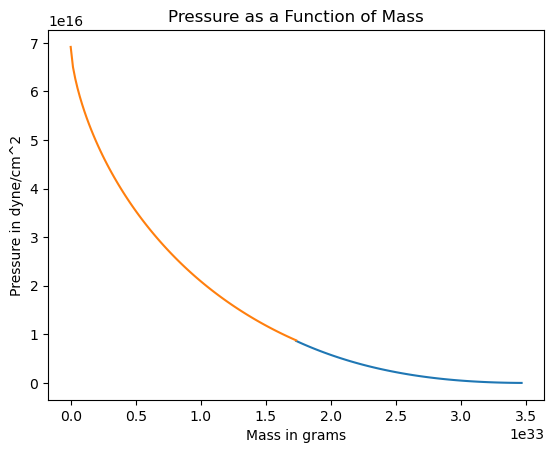

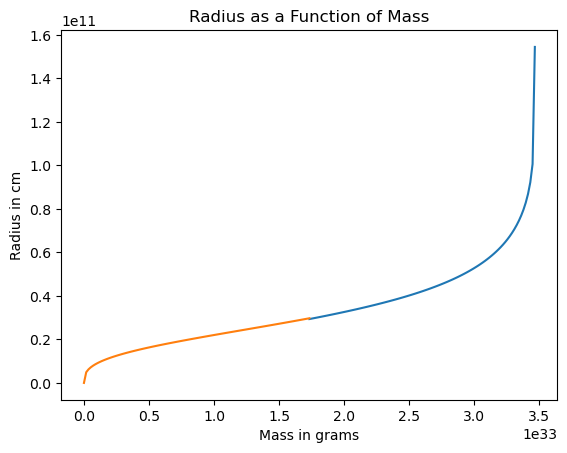

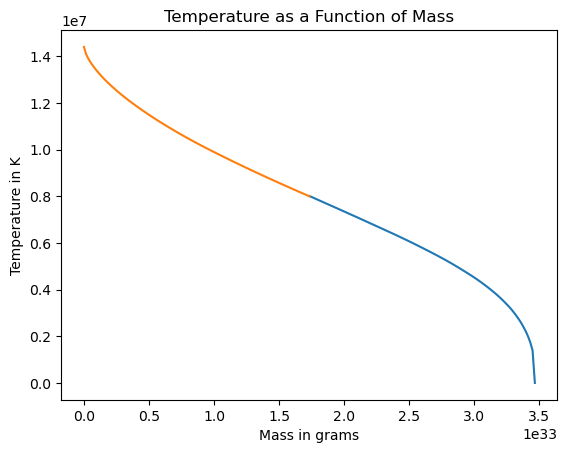

In [92]:
plt.title("Luminosity as a Function of Mass")
plt.plot(m_in,in_res[0])
plt.plot(m_out,out_res[0])
plt.xlabel('Mass in grams')
plt.ylabel('Luminosity in erg/s')
plt.savefig('lum_plot_1.pdf')
plt.show()

plt.title("Pressure as a Function of Mass")
plt.plot(m_in,in_res[1])
plt.plot(m_out,out_res[1])
plt.xlabel('Mass in grams')
plt.ylabel('Pressure in dyne/cm^2')
plt.savefig('press_plot_1.pdf')
plt.show()

plt.title("Radius as a Function of Mass")
plt.plot(m_in,in_res[2])
plt.plot(m_out,out_res[2])
plt.xlabel('Mass in grams')
plt.ylabel('Radius in cm')
plt.savefig('rad_plot_1.pdf')
plt.show()

plt.title("Temperature as a Function of Mass")
plt.plot(m_in,in_res[3])
plt.plot(m_out,out_res[3])
plt.xlabel('Mass in grams')
plt.ylabel('Temperature in K')
plt.savefig('temp_plot_1.pdf')
plt.show()

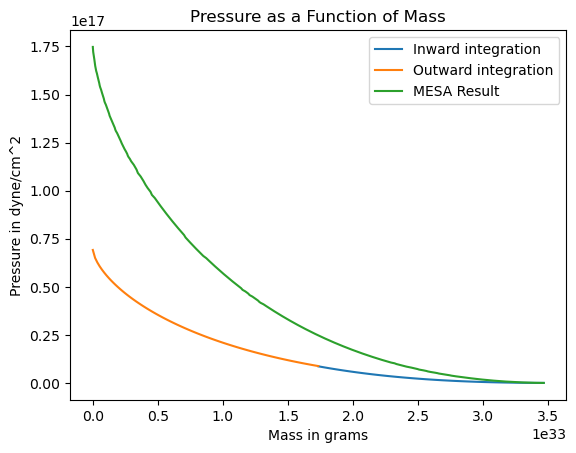

In [93]:
import mesa_reader as mr

dat=mr.MesaLogDir('./LOGS_175Msun')
p=dat.profile_data()
#print("Last R",p.R[0]*Rs)
#l,p,r,t
#plt.plot(m_in,in_res[1])
#plt.plot(m_out,out_res[1])
#plt.plot(p.mass*M_sun,p.P)
#plt.plot(p.mass*M_sun,p.R*Rs)
#plt.plot(p.mass*M_sun,p.T)
#plt.show()

plt.title("Pressure as a Function of Mass")
plt.plot(m_in,in_res[1],label='Inward integration')
plt.plot(m_out,out_res[1],label='Outward integration')
plt.xlabel('Mass in grams')
plt.ylabel('Pressure in dyne/cm^2')
plt.plot(p.mass*M_sun,p.P,label='MESA Result')
plt.legend()
plt.savefig('press_plot_2.pdf')
plt.show()

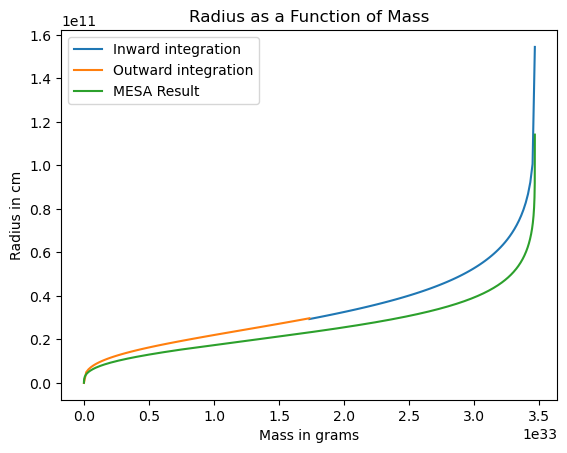

In [94]:

plt.title("Radius as a Function of Mass")
plt.plot(m_in,in_res[2],label='Inward integration')
plt.plot(m_out,out_res[2],label='Outward integration')
plt.plot(p.mass*M_sun,p.R*Rs,label='MESA Result')
plt.xlabel('Mass in grams')
plt.ylabel('Radius in cm')
plt.legend()
plt.savefig('rad_plot_2.pdf')
plt.show()

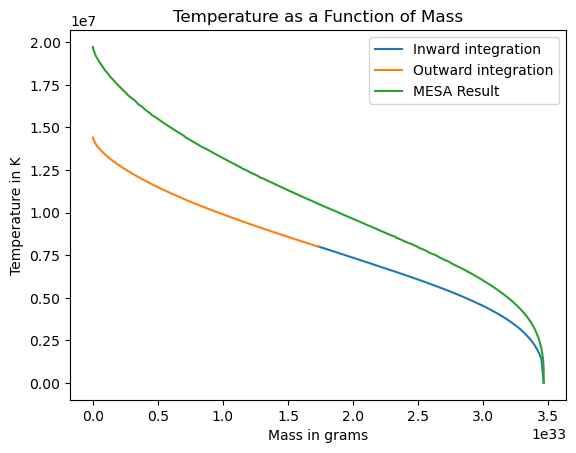

In [95]:
plt.title("Temperature as a Function of Mass")
plt.plot(m_in,in_res[3],label='Inward integration')
plt.plot(m_out,out_res[3],label='Outward integration')
plt.plot(p.mass*M_sun,p.T,label='MESA Result')
plt.xlabel('Mass in grams')
plt.ylabel('Temperature in K')
plt.legend()
plt.savefig('temp_plot_2.pdf')
plt.show()

In [96]:
#Compare the values
print("Project Radius: ", in_res[2][0])
print("MESA Radius: ", p.R[0]*Rs)
print("Percent Difference: ", (in_res[2][0]-p.R[0]*Rs)/in_res[2][0])
#print("Percent Difference: ", (in_res[2][0]-p.R[0]*Rs)/(p.R[0]*Rs))

print("Project Temperature: ", in_res[3][0])
print("MESA Temperature: ", p.T[0])
print("Percent Difference: ", np.abs((in_res[3][0]-p.T[0]))/p.T[0])

l_mesa=4*np.pi*(p.R[0]*Rs)**2*p.T[0]**4
print("Project Luminosity: ", in_res[0][0])
print("MESA Luminosity: ", l_mesa)
print("Percent Difference: ", np.abs((in_res[0][0]-l_mesa))/l_mesa)

surf_grav=G*M*M_sun/in_res[2][0]**2
surf_mesa=G*M*M_sun/(p.R[0]*Rs)**2

print("Project Surface Gravity: ", surf_grav)
print("MESA Surface Gravity: ", surf_mesa)
print("Percent Difference: ", np.abs((surf_grav-surf_mesa))/surf_mesa)

Project Radius:  154427071883.93744
MESA Radius:  114129002577.08759
Percent Difference:  0.26095210389753826
Project Temperature:  4802.182611672288
MESA Temperature:  7728.960513924683
Percent Difference:  0.3786767828583729
Project Luminosity:  8.861070924129886e+33
MESA Luminosity:  5.840987298534701e+38
Percent Difference:  0.9999848294980433
Project Surface Gravity:  9691.303607109649
MESA Surface Gravity:  17743.407601583476
Percent Difference:  0.4538082072665249


In [97]:
#make the table
#format: m,l,p,r,t,rho,epsilon,kappa,del-ad,del-rad,conv/rad
#print(m_out)
m=np.concatenate((m_out,m_in)) # mass
print(len(m))
l=np.concatenate((out_res[0],in_res[0]))
print(len(l))
p=np.concatenate((out_res[1],in_res[1]))
print(len(p))
r=np.concatenate((out_res[2],in_res[2]))
print(len(r))
t=np.concatenate((out_res[3],in_res[3]))
print(len(t))
rho=calc_density(p,t)
print(len(rho))
eps=[]
for i in range(len(rho)):
    e=nuc_energy(rho[i],t[i])
    eps.append(e)
eps=np.array(eps)
kappa=[]
for i in range(len(rho)):
    k=get_opacity(opacity_interp, rho[i], t[i])
    kappa.append(k)
kappa=np.array(kappa)
#print(kappa)
#kappa=get_opacity(interp, rho, t)
del_ad=ad_nab(t,p)
del_rad=rad_nab(m,l,p,t,kappa)
typ=[]
for i in range(len(del_ad)):
    if del_ad[i]<del_rad[i]:
        typ.append(1)
    else:
        typ.append(0)
typ=np.array(typ)

data=np.array([m,l,p,r,t,rho,eps,kappa,del_ad,del_rad,typ])
#data=[m,l,p,r,t,rho,eps,kappa,del_ad,del_rad,typ]
print(data)

head='Table format: m,l,p,r,t,rho,epsilon,kappa,del-ad,del-rad,conv/rad (0 or 1)'
np.savetxt('Stellar_data_table_1.txt',data,header=head)

200
200
200
200
200
200
[[3.46500000e+25 1.75000343e+31 3.50000340e+31 ... 1.76750000e+33
  1.75000000e+33 1.73250000e+33]
 [9.03415861e+24 4.21794735e+32 8.05359302e+32 ... 8.80120523e+33
  8.79776691e+33 8.79416561e+33]
 [6.91599366e+16 6.50107788e+16 6.26312126e+16 ... 8.22031752e+15
  8.43095464e+15 8.64546095e+15]
 ...
 [3.98132314e-01 3.98186393e-01 3.98216858e-01 ... 3.98554532e-01
  3.98559275e-01 3.98563852e-01]
 [3.73972990e-03 3.66545907e-01 3.62122591e-01 ... 2.16536099e-01
  2.17465546e-01 2.18532993e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
